# Model Inference and Image Post-Processing
In this Notebook, we'll do the following.

* Apply the trained model on new images
* Use classic computer vision techniques such as contour approximation to refine segmentation boundaries

### Load in necessary modules

In [137]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import os

In [139]:
from mmdet.apis import init_detector, inference_detector
import mmcv
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Define functions for reading image, obtaining segmentation details, and refining results

In [140]:
def read_image(path):
    image = imageio.imread(path)
    return image

In [141]:
def segm_detail(image, result, model, score_thr=0.5, ):
    if isinstance(result, tuple):
        bbox_result, segm_result = result
    else:
        bbox_result, segm_result = result, None
    bboxes = np.vstack(bbox_result)

    labels = [
            np.full(bbox.shape[0], i, dtype=np.int32)
            for i, bbox in enumerate(bbox_result)
        ]

    # bboxes, labels pair contain info for each segmentation, len(bboxes) = len(labels)        
    # label (in the form of integer) indicates the index of the class_names                    
    labels = np.concatenate(labels)                                                            
    return labels, bboxes, segm_result

In [142]:
def getApproxCorner(hull, coef=0.03, corner=4):
    epsilon = coef*cv2.arcLength(hull,True)
    approx = cv2.approxPolyDP(hull,epsilon,True)
    while len(approx) != corner:
        if len(approx) > corner:
            coef += 0.001
            epsilon = coef*cv2.arcLength(hull,True)
            approx = cv2.approxPolyDP(hull,epsilon,True)
        elif len(approx) < corner:
            coef -= 0.001
            epsilon = coef*cv2.arcLength(hull,True)
            approx = cv2.approxPolyDP(hull,epsilon,True)
    assert(len(approx) == corner)
    return approx

### Load model and run inference on example image

In [143]:
model_dir = '/home/yxw4wp8/14-mmdet_2.0/mmdetection/work_dirs/kdd/mask_rcnn_r2_101'

config_file = os.path.join(model_dir, 'mask_rcnn_r2_101_fpn_2x_coco.py')
model_file = os.path.join(model_dir, 'epoch_18.pth')
model = init_detector(config_file, model_file, device='cuda:0')

print(model.CLASSES)

('door | doorframe, doorcase | double door', 'bed | bedpost | blanket, cover | headboard', 'wardrobe, closet, press', 'lamp', 'chest of drawers, chest, bureau, dresser | chest', 'pillow', 'armchair | chair | swivel chair', 'pane, pane of glass, window glass | windowpane, window', 'curtain, drape, drapery, mantle, pall', 'mirror', 'painting, picture | frame', 'wall', 'ceiling', 'floor, flooring', 'cabinet')


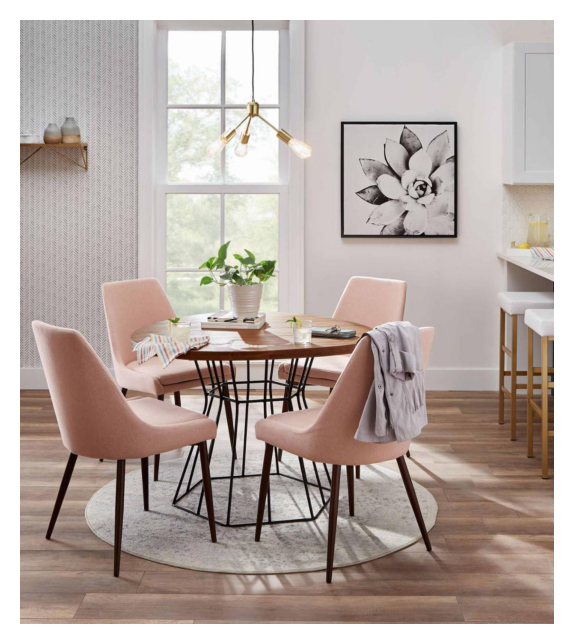

In [144]:
img = read_image('https://images.homedepot-static.com/lifestyleimages/1024x682/c5ace81b-43ea-4428-bb47-a7d528ba7c0211.jpeg')
fig = plt.figure(dpi=200, figsize=(8, 4))
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

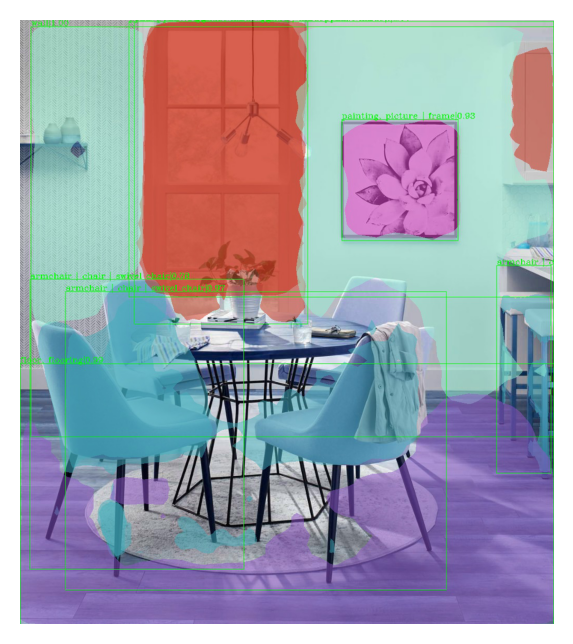

In [145]:
result = inference_detector(model, img)
model.show_result(img, result, score_thr=0.5, out_file='result.jpg')
inf = read_image('result.jpg')
fig = plt.figure(dpi=200, figsize=(8, 4))
infplot = plt.imshow(inf)
plt.axis("off")
plt.show()

In [146]:
class_dict = {model.CLASSES[i]:i for i in range(len(model.CLASSES))}
print(class_dict)
labels, bboxes, segm_result = segm_detail(img, result, model)
segms = mmcv.concat_list(segm_result)

# filter segmentation results by confidence level
inds = np.where(bboxes[:, -1] > 0.5)[0]
print(inds)
# # rank segmentation by confidence level
arg_sort = np.argsort(-bboxes[:, -1])
sorted_inds = [arg for arg in arg_sort if arg in inds]

# obtain segmentaion corresponding to painting/picture frames
picture_segms = [segms[j] for j in sorted_inds if labels[j] == class_dict['painting, picture | frame']]

{'door | doorframe, doorcase | double door': 0, 'bed | bedpost | blanket, cover | headboard': 1, 'wardrobe, closet, press': 2, 'lamp': 3, 'chest of drawers, chest, bureau, dresser | chest': 4, 'pillow': 5, 'armchair | chair | swivel chair': 6, 'pane, pane of glass, window glass | windowpane, window': 7, 'curtain, drape, drapery, mantle, pall': 8, 'mirror': 9, 'painting, picture | frame': 10, 'wall': 11, 'ceiling': 12, 'floor, flooring': 13, 'cabinet': 14}
[ 2  3  4  7  8 11 13 14]


### Refine segmentation results

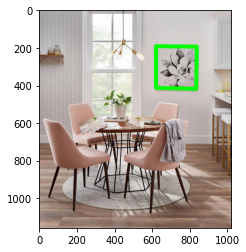

In [161]:
imCopy = img.copy()
for i in range(len(picture_segms)):
    mask = picture_segms[i]
    # obtain raw contours for the segmentation
    contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # get an approximated contour with only 4 corners
    approx = getApproxCorner(contours[0], coef=0.03, corner=4)
    cv2.drawContours(imCopy, [approx], 0, (0,255,0), 20)
    plt.imshow(imCopy)

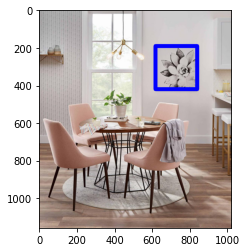

In [162]:
imCopy = img.copy()
for i in range(len(picture_segms)):
    mask = picture_segms[i]
    # obtain raw contours for the segmentation
    contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # get an approximated minimum area rectangle bounding the contour
    rect = cv2.minAreaRect(contours[0])
    box = cv2.boxPoints(rect) 
    box = np.int0(box)
    cv2.drawContours(imCopy,[box],0,(0,0,255),20)
    plt.imshow(imCopy)

### Another example

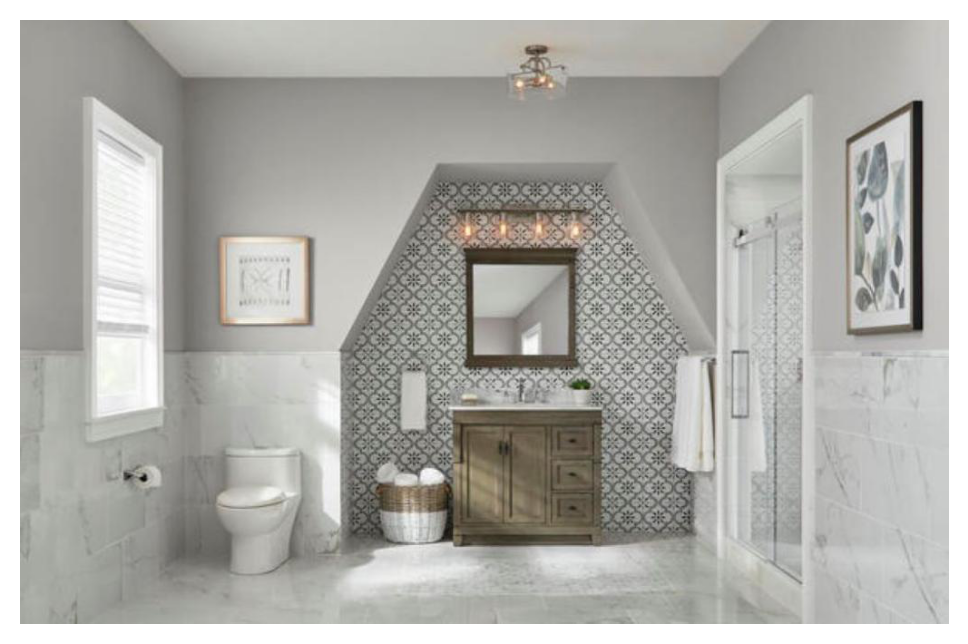

In [148]:
img2 = read_image('https://images.homedepot-static.com/lifestyleimages/1024x682/080654fe-6f08-4c28-8d7f-9e48fed449692.jpeg')
fig2 = plt.figure(dpi=200, figsize=(8, 4))
imgplot2 = plt.imshow(img2)
plt.axis("off")
plt.show()

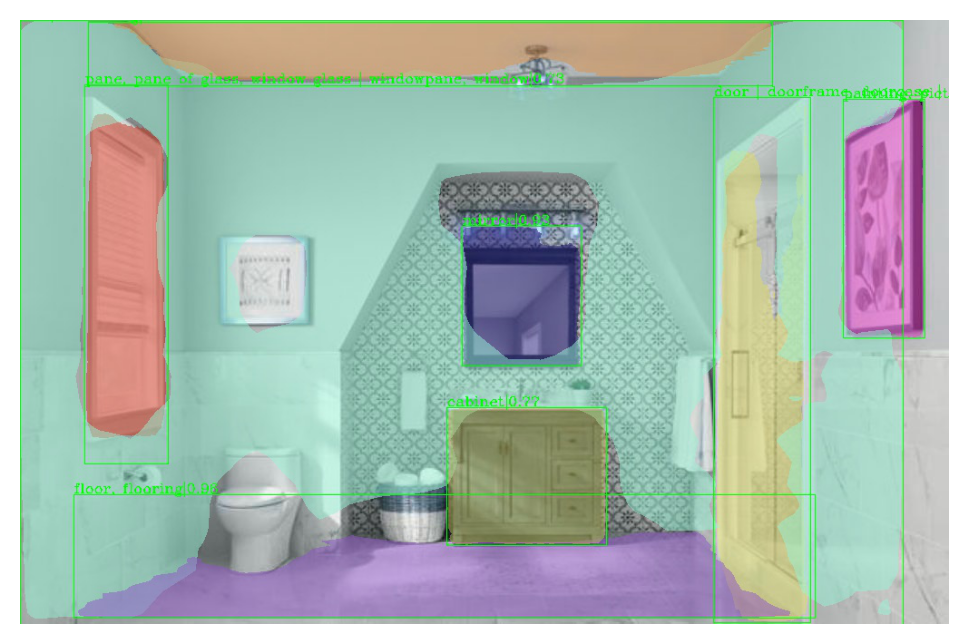

In [149]:
result2 = inference_detector(model, img2)
model.show_result(img2, result2, score_thr=0.5, out_file='result2.jpg')
inf2 = read_image('result2.jpg')
fig2 = plt.figure(dpi=200, figsize=(8, 4))
infplot2 = plt.imshow(inf2)
plt.axis("off")
plt.show()

In [151]:
labels2, bboxes2, segm_result2 = segm_detail(img2, result2, model)
segms2 = mmcv.concat_list(segm_result2)

# filter segmentation results by confidence level
inds2 = np.where(bboxes2[:, -1] > 0.5)[0]
print(inds2)
# # rank segmentation by confidence level
arg_sort2 = np.argsort(-bboxes2[:, -1])
sorted_inds2 = [arg for arg in arg_sort2 if arg in inds2]

# obtain segmentaion corresponding to painting/picture frames
window_segms = [segms2[j] for j in sorted_inds2 if labels2[j] == class_dict['pane, pane of glass, window glass | windowpane, window']]

[ 0  7 11 13 21 22 24 25]


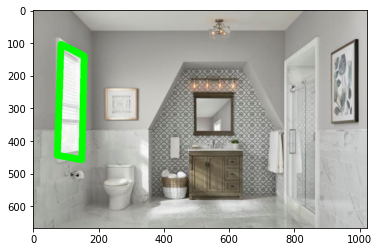

In [152]:
imCopy2 = img2.copy()
for i in range(len(window_segms)):
    mask = window_segms[i]
    # obtain raw contours for the segmentation
    contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    approx = getApproxCorner(contours[0], coef=0.03, corner=4)
    cv2.drawContours(imCopy2, [approx], 0, (0,255,0), 20)
    plt.imshow(imCopy2)